## Twitter Sentiment Analysis
#### References:
* Training the NaiveBayesClassifier - https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk#step-1-%E2%80%94-installing-nltk-and-downloading-the-data
* NLP - https://www.youtube.com/watch?v=xvqsFTUsOmc , https://github.com/adashofdata/nlp-in-python-tutorial

#### What I would do to improve analysis:
* Intent analysis - find the user's intention behind the tweet
* Analyze larger tweet datasets
* Lemmatize words like "Hi" and "Hiiiii"
* Detect sarcasm in tweet
* Sentiment analysis API service: https://www.paralleldots.com/sentiment-analysis

In [48]:
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem.wordnet import WordNetLemmatizer  #lemmatize text (running=run)
from nltk.tag import pos_tag  #assign positional tags to tokens (noun, verb, adjective)
import re, string  #filter regular expressions
from nltk import NaiveBayesClassifier  # classifier algorithm
from nltk import classify  #classify tweets as positive or negative
from nltk import FreqDist  #determine the most frequent words in analysis
from nltk.tokenize import word_tokenize  #tokenize words
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tweepy
import warnings
warnings.filterwarnings("ignore")
from config import api_key, secret_api_key, access_token, secret_access_token

In [2]:
# viewing json files inside twitter_samples data
twitter_samples.fileids()

['negative_tweets.json', 'positive_tweets.json', 'tweets.20150430-223406.json']

### Checking for bias in the NLTK twitter corpus
#### Wrangling data from corpus and twitter API

In [3]:
# combining NLTK positive and negative datasets
user_created_at = [i["user"]["created_at"] for i in twitter_samples.docs("positive_tweets.json")] + [i["user"]["created_at"] for i in twitter_samples.docs("negative_tweets.json")]
user_language = [i["user"]["lang"] for i in twitter_samples.docs("positive_tweets.json")] + [i["lang"] for i in twitter_samples.docs("negative_tweets.json")]
user_followers_count = [i["user"]["followers_count"] for i in twitter_samples.docs("positive_tweets.json")] + [i["user"]["followers_count"] for i in twitter_samples.docs("negative_tweets.json")]
user_status_count = [i["user"]["statuses_count"] for i in twitter_samples.docs("positive_tweets.json")] + [i["user"]["statuses_count"] for i in twitter_samples.docs("negative_tweets.json")]
user_friend_count = [i["user"]["friends_count"] for i in twitter_samples.docs("positive_tweets.json")] + [i["user"]["friends_count"] for i in twitter_samples.docs("negative_tweets.json")]
user_verified = [i["user"]["verified"] for i in twitter_samples.docs("positive_tweets.json")] + [i["user"]["verified"] for i in twitter_samples.docs("negative_tweets.json")]
corpus_tweets = [i["text"] for i in twitter_samples.docs("positive_tweets.json")] + [i["text"] for i in twitter_samples.docs("negative_tweets.json")]

# creating dataframe
corpus_df = pd.DataFrame({
    "user_created_at":user_created_at,
    "user_language":user_language,
    "user_followers_count":user_followers_count,
    "user_status_count":user_status_count,
    "user_friend_count":user_friend_count,
    "user_verified":user_verified,
    "tweet":corpus_tweets
})

corpus_df.head()

,user_created_at,user_language,user_followers_count,user_status_count,user_friend_count,user_verified,tweet
0,Thu Feb 18 13:18:49 +0000 2010,fr,3683,12858,1505,False,#FollowFriday @France_Inte @PKuchly57 @Milipol...
1,Mon Feb 09 14:30:33 +0000 2009,en,22528,13135,834,False,@Lamb2ja Hey James! How odd :/ Please call our...
2,Mon Aug 23 12:16:57 +0000 2010,en,187,1335,482,False,@DespiteOfficial we had a listen last night :)...
3,Tue Jul 24 20:38:16 +0000 2012,fr,3231,39809,1052,False,@97sides CONGRATS :)
4,Tue Jul 29 11:52:14 +0000 2014,en,398,2887,56,False,yeaaaah yippppy!!! my accnt verified rqst has...


In [4]:
# establishing connection to twitter api
auth = tweepy.OAuthHandler(api_key, secret_api_key)
auth.set_access_token(access_token, secret_access_token)
api = tweepy.API(auth)

# requesting API
response = api.search(q="all",count=100,tweet_mode="extended")

# compiling data
api_df = pd.DataFrame({
    "user_created_at":[i.user.created_at for i in response],
    "user_language":[i.lang for i in response],
    "user_followers_count":[i.user.followers_count for i in response],
    "user_status_count":[i.user.statuses_count for i in response],
    "user_friend_count":[i.user.friends_count for i in response],
    "user_verified":[i.user.verified for i in response],
    "tweet":[i.full_text for i in response]
})
api_df.head()

,user_created_at,user_language,user_followers_count,user_status_count,user_friend_count,user_verified,tweet
0,2020-07-15 06:26:36,en,3,161,10,False,RT @mfcevy: i love that he took a moment to ta...
1,2012-10-30 20:24:45,en,2081,5797,3235,False,"RT @RepVernonJones: On Monday, I look forward ..."
2,2016-10-23 18:48:43,en,352,84927,17,False,RT @HikindDov: This “opinion” of Hill’s is sic...
3,2016-06-24 03:26:49,en,697,13236,801,False,RT @RipTorn18: RED IT UP PATRIOTS 🇺🇸🇺🇸!! The R...
4,2017-07-21 02:23:19,en,25,10494,157,False,RT @sheisresting: i dont like that ppl try to ...


In [5]:
# top 5 languages and tweet counts
corpus_df["user_language"].value_counts()[:5]

en       9261
en-gb     171
id        100
fr         96
de         75
Name: user_language, dtype: int64

#### Understanding the model's vocabulary
* The model is being trained to classify tweets in english
* It will struggle to accuratly classify tweets in any other language

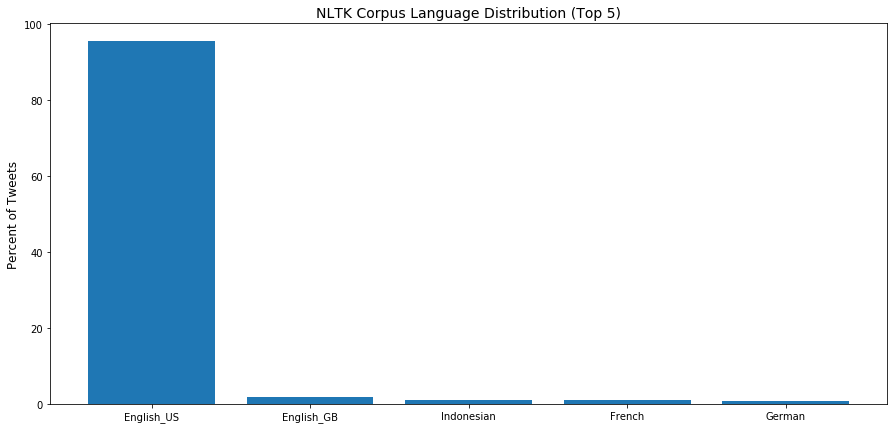

In [6]:
# converting language counts to percentage
counts = corpus_df["user_language"].value_counts()[:5]
total = counts.sum()
points = []
for i in counts:
    percent = round(i/total*100,2)
    points.append(percent)
    
# plotting
labels = ["English_US","English_GB","Indonesian","French","German"]
plt.figure(figsize=(15,7))
plt.bar(np.arange(5),points)
plt.xticks(np.arange(5),labels)
plt.title("NLTK Corpus Language Distribution (Top 5)", size=14)
plt.ylabel("Percent of Tweets",size=12)
plt.show()

In [7]:
# calculating means across corpus and real-time tweets
api_avg_followers = api_df["user_followers_count"].mean()
corpus_avg_followers = corpus_df["user_followers_count"].mean()
api_avg_statuses = api_df["user_status_count"].mean()
corpus_avg_statuses = corpus_df["user_status_count"].mean()
api_avg_friend_count = api_df["user_friend_count"].mean()
corpus_avg_friend_count = corpus_df["user_friend_count"].mean()
api_avg_user_verified = len(api_df.loc[api_df["user_verified"]=="True"])
corpus_avg_user_verified = len(corpus_df.loc[corpus_df["user_verified"]=="True"])
api = [api_avg_followers,api_avg_statuses,api_avg_friend_count,api_avg_user_verified]
corpus = [corpus_avg_followers, corpus_avg_statuses, corpus_avg_friend_count, corpus_avg_user_verified]

#### Comparing user characteristics
* Average user characteristics of 100 real-time tweets are compared to average user characteristics from NLTK corpus tweets
* Similar distribution of user profile characteristics suggests the NLTK data accuratly describes the average twitter user

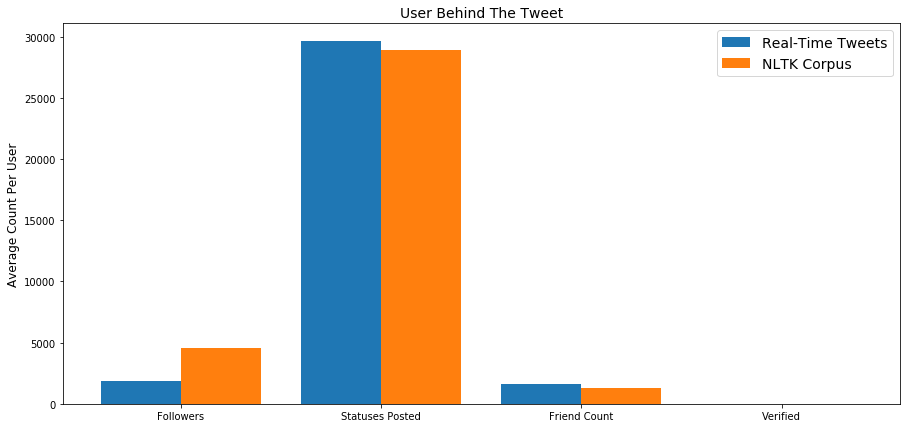

In [8]:
# plotting
x_values = np.arange(4)
labels = ["Followers","Statuses Posted","Friend Count","Verified"]
width = 0.4
plt.figure(figsize=(15,7))
plt.bar(x_values, api , width, label="Real-Time Tweets")
plt.bar(x_values + width, corpus, width, label="NLTK Corpus")
plt.xticks(x_values+width/2,labels)
plt.legend(loc="best",prop={'size': 14})
plt.ylabel("Average Count Per User", size=12)
plt.title("User Behind The Tweet",size=14)
plt.show()

In [9]:
# converting tweets into one large string value
api_tweets = api_df['tweet'].str.lower().str.cat(sep=' ')
corpus_tweets = corpus_df['tweet'].sample(100).str.lower().str.cat(sep=' ')

# normalizing the data
stop_words=set(stopwords.words('english'))
api_tokenize=word_tokenize(api_tweets)
corpus_tokenize=word_tokenize(corpus_tweets)
# filtering punctuation, numbers, spaces, etc
api_alpha_tokenize=[word for word in api_tokenize if word.isalpha()]
corpus_alpha_tokenize=[word for word in corpus_tokenize if word.isalpha()]
# filtering stop words, rt
api_filtered_tokenize=[word for word in api_alpha_tokenize if not word in stop_words and word != "rt"]
corpus_filtered_tokenize=[word for word in corpus_alpha_tokenize if not word in stop_words and word != "rt"]

#### Word frequency distribution
* Plotting the distribution of words across both datasets
* Similar distributions with limited skewness indicates a lower chance of bias in the NLTK training dataset

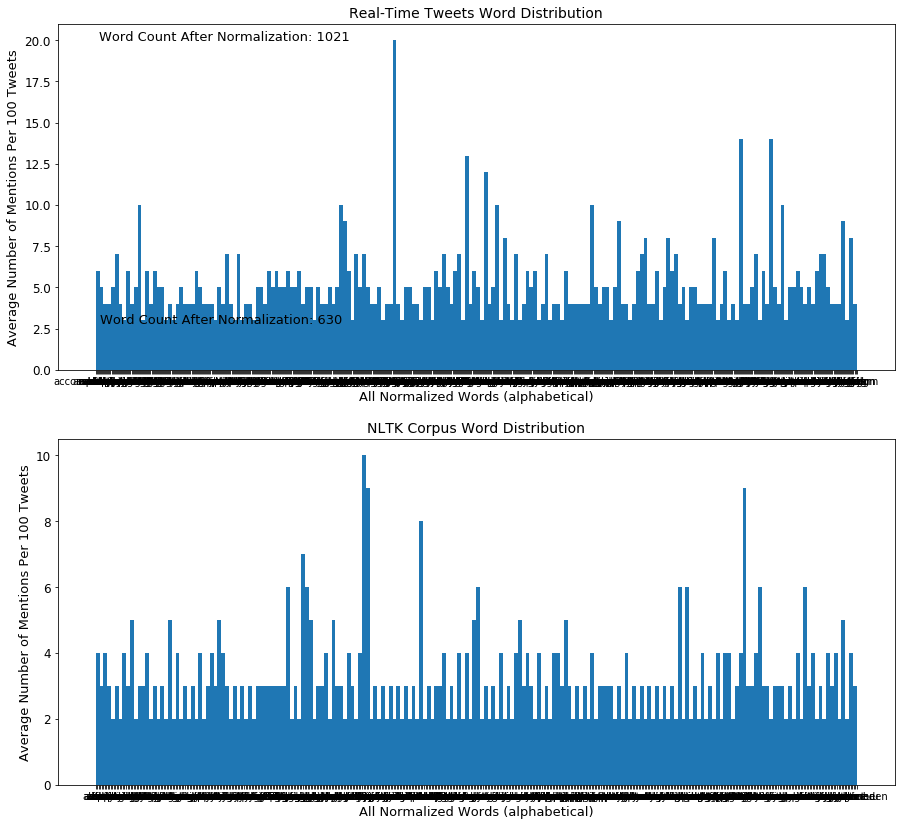

In [10]:
fig, [ax1,ax2] = plt.subplots(2,1, figsize=(15,14))
# twitter api
ax1.hist(sorted(api_filtered_tokenize), bins=200)
ax1.set_title("Real-Time Tweets Word Distribution",size=14)
ax1.set_ylabel("Average Number of Mentions Per 100 Tweets",size=13)
ax1.set_xlabel("All Normalized Words (alphabetical)",size=13)
ax1.tick_params(axis='y', which='major', labelsize=12)
ax1.text(3, 20, f"Word Count After Normalization: {len(api_filtered_tokenize)}",fontsize=13)
# ax1.axhline(5,color='black',ls='-')

# corpus 
ax2.hist(sorted(corpus_filtered_tokenize), bins=200)
ax2.set_title("NLTK Corpus Word Distribution",size=14)
ax2.set_ylabel("Average Number of Mentions Per 100 Tweets",size=13)
ax2.set_xlabel("All Normalized Words (alphabetical)",size=13)
ax2.tick_params(axis='y', which='major', labelsize=12)
ax2.text(3, 14, f"Word Count After Normalization: {len(corpus_filtered_tokenize)}",fontsize=13)
# ax2.axhline(5,color='black',ls='-')
plt.show()

### Training the NaiveBayesClassifier algorithm

In [280]:
# remove undesired text from tokens (puncuation, numbers & symbols, stop words)
def clean_data(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        # removing unwanted symbols and patterns from tokens using regular expressions
        token = re.sub("http[s]?://+(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+","", token)
        token = re.sub(".(.co/o).","", token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        token = re.sub("\w*\d\w*","",token)
        token = re.sub('[‘’“”…#–/]', '', token)
        token = re.sub("http[s]?","",token)
        
        # assigning new pos tags for WordNetLemmatizer() function
        if tag.startswith("NN"):
            pos = "n"
        elif tag.startswith("VB"):
            pos = "v"
        else:
            pos = "a"
            
        # lemmatizing tokens (running=run)
        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)
        
        # dropping puncuation and stop words
        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens
            
# covert list to dictionary with keys=tokens and values=true
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

#### Tokenizing, cleaning and assembling the dataset

In [281]:
# tokenizing positive/negative tweets
positive_tokens = twitter_samples.tokenized("positive_tweets.json")
negative_tokens = twitter_samples.tokenized("negative_tweets.json")

# cleaning and prepping tokens for analysis
positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []
for tokens in positive_tokens:
    positive_cleaned_tokens_list.append(clean_data(tokens, stop_words))
for tokens in negative_tokens:
    negative_cleaned_tokens_list.append(clean_data(tokens, stop_words))

In [282]:
# converting lists of tokens to dictionaries with keys=tokens and values=True
positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

# creating dataset with assigned positive and negative setiment values
positive_dataset = [(tweet_dict, "Positive") for tweet_dict in positive_tokens_for_model]
negative_dataset = [(tweet_dict, "Negative") for tweet_dict in negative_tokens_for_model]

# combining and shuffling positive and negative datasets 
dataset = positive_dataset + negative_dataset
random.shuffle(dataset)

# splitting dataset into train/test data
train_data = dataset[:7000]
test_data = dataset[7000:]

#### Training and testing the NaiveBayesClassifier

In [283]:
# training the NaiveBayesClassifier algorithm
classifier = NaiveBayesClassifier.train(train_data)
# assessing the accuracy of the algorithm
print("Accuracy is:", classify.accuracy(classifier, test_data))
# displaying the most informative words
print(classifier.show_most_informative_features(10))

Accuracy is: 0.996
Most Informative Features
                      :) = True           Positi : Negati =   1664.9 : 1.0
                follower = True           Positi : Negati =     33.8 : 1.0
                     sad = True           Negati : Positi =     23.7 : 1.0
                     bam = True           Positi : Negati =     23.1 : 1.0
                    glad = True           Positi : Negati =     21.8 : 1.0
                      ff = True           Positi : Negati =     20.4 : 1.0
                 welcome = True           Positi : Negati =     15.9 : 1.0
                    blog = True           Positi : Negati =     15.1 : 1.0
                  friday = True           Positi : Negati =     13.6 : 1.0
                  arrive = True           Positi : Negati =     13.4 : 1.0
None


##### Testing the NaiveBayesClassifier on custom text

In [293]:
custom_tweet = "The chipotle burrito I had was so good"

custom_tokens = clean_data(word_tokenize(custom_tweet))
result = classifier.classify(dict([token, True] for token in custom_tokens))
result

'Positive'

### Live Twitter Sentiment Analysis
* Returns a 'sentiment score' calculated by the NaiveBayesClassifier for any topic provided by the user
* 100 real-time tweets posted within the last seven days are analyzed to determine positive or negative sentiment

In [285]:
# enable twitter api authorization
auth = tweepy.OAuthHandler(api_key, secret_api_key)
auth.set_access_token(access_token, secret_access_token)
api = tweepy.API(auth)

# ask user for name of sentimate analysis subject
user_input = input("Enter the name of the topic to analyze for sentimate :")
if user_input == "":
    user_input = input("Enter the name of the topic to analyze for sentimate :")
    if user_input == "":
        exit()

# request the twitter api
total_tweet_count = 100
response = api.search(q=user_input,count=total_tweet_count,tweet_mode="extended",lang="en",result_type="mixed") #result_type=mixed, recent, popular

Enter the name of the topic to analyze for sentimate :chipotle


In [286]:
# tally positive and negative results based on the NaiveBayesClassifier algorithm
positive_result=0
negative_result=0
positive_tweets = []
negative_tweets = []
for tweet in response:
    tweet_text = tweet.full_text
    tweet_tokens = clean_data(word_tokenize(tweet_text))
    result = classifier.classify(dict([token, True] for token in tweet_tokens))
    if result == "Negative":
        negative_result += 1
        negative_tweets.append(tweet.full_text)
    elif result == "Positive":
        positive_result += 1
        positive_tweets.append(tweet.full_text)
print(f"Positive results: {positive_result}")
print(f"Negative results: {negative_result}")

Positive results: 37
Negative results: 63


- The **Sentimate Score** is calculated using the formula *sentimate_score = (number of positive results / number of tweets analyzed) x 5*

In [287]:
# calculate sentiment score
sentiment_score = round((positive_result/total_tweet_count) * 5,2)
print(f"""'{user_input.title()}' scores a {sentiment_score} out of 5.
""")
print(f"""Positive Tweet Example: '{random.choice(positive_tweets)}'
""")
print(f"Negative Tweet Example: '{random.choice(negative_tweets)}'")

'Chipotle' scores a 1.85 out of 5.

Positive Tweet Example: '@BrookeRoust Oh no. Message us here: https://t.co/ltrG42NaPA so we can help. -Alex'

Negative Tweet Example: 'there is a TWENTY DOLLAR delivery fee for this chipotle'
